In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import os

In [2]:
class PerfForHardware:
    def __init__(self, device_name, perf, size=None):
        self.device = device_name
        self.perf = perf
        self.size = size
        pass

In [3]:
class Conv1dParams:
    def __init__(self, batch_size, length, k, channels):
        self.batch_size = batch_size
        self.length = length
        self.k = k
        self.channels = channels

    def title(self):
        return f"Perf (GB/s) for size: n={self.batch_size}, l={self.length}, k={self.k}, oc=ic={self.channels}"

    def __repr__(self):
        return (f"Conv1dParams(batch_size={self.batch_size}, length={self.length}, "
                f"k={self.k}, channels={self.channels})")
    
    def __eq__(self, other):
        if not isinstance(other, Conv1dParams):
            return NotImplemented
        return (self.batch_size == other.batch_size and
                self.length == other.length and
                self.k == other.k and
                self.channels == other.channels)
    
    def __hash__(self):
        return hash((self.batch_size, self.length, self.k, self.channels))


In [4]:
class Conv1dPlotter:
    def __init__(self, params_setup: Conv1dParams, *perf_data, log_scale=False):
        self.labels = ["TORCH", "ACPP", "DPCPP"]
        self.colors = [
            "#e66349",
            "#E63946",
            "#0071C5",
        ]  # Custom colors for each category
        self.log_scale = log_scale

        self.params = params_setup
        self.perf_data = perf_data
        pass

    def plot(self, ax=None):
        hardwares = [run.device for run in self.perf_data[0]]  # Assume all lists are aligned
        x = np.arange(len(hardwares))  # X-axis positions
        width = 0.25  # Bar width

        if ax is None:
            fig, ax = plt.subplots()

        if self.log_scale:
            f = np.log
        else:
            f = lambda x: x

        # Iterate over each dataset (TORCH, ACPP, DPCPP)
        for i, (data, label, color) in enumerate(zip(self.perf_data, self.labels, self.colors)):
            values = [f(run.perf) if run.perf is not None else np.nan for run in data]
            ax.bar(x + (i - 1) * width, values, width, label=label, color=color)

        # Labels and formatting
        ax.set_ylabel(f'{"log-Performance" if self.log_scale else "Performance"}')
        ax.set_title(self.params.title())
        ax.set_xticks(x)
        ax.set_xticklabels(hardwares)
        ax.legend()
        ax.grid()

In [5]:
configs = []

with open("conv1d.json", "r") as f:
    data = json.load(f)

all_perfs = {}

for entry in data["RESULTS"]:
    new_config = Conv1dParams(
        entry["batch_size"],
        entry["input_length"],
        entry["kernel_size"],
        entry["channels"],
    )
    # configs.append(new_config)

    all_perfs[new_config] = {}
    impl = entry["impl"]

    if len(all_perfs[new_config][impl]) > 0:
        all_perfs[new_config][impl] = []

    for hw in ['h100', 'mi300', 'pvc']:
        entry_id = hw+"_perf"
        all_perfs[new_config][impl].append(PerfForHardware(hw, entry[entry_id]))

KeyError: 'dpcpp'

KeyError: 'torch'

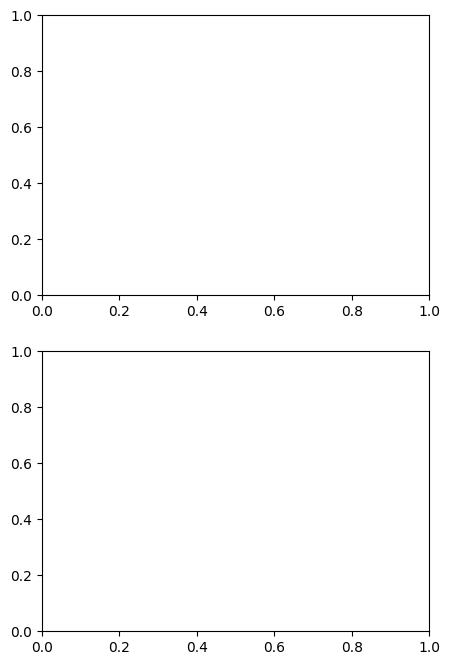

In [ ]:

# Determine the number of subplots
num_configs = len(all_perfs)
cols = 2  # You can change this to 3 if you prefer wider layout
rows = (num_configs + cols - 1) // cols  # Compute rows needed

fig, axes = plt.subplots(cols, rows, figsize=(rows * 5, cols * 4))  # Adjust figure size
axes = axes.flatten()  # Flatten in case of multi-dimensional array

for i, (config, v) in enumerate(all_perfs.items()):
    plotter = Conv1dPlotter(
        config,
        all_perfs[config]["torch"],
        all_perfs[config]["acpp"],
        all_perfs[config]["dpcpp"],
        log_scale=False
    )
    plotter.plot(ax=axes[i])  # Pass the subplot axis

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

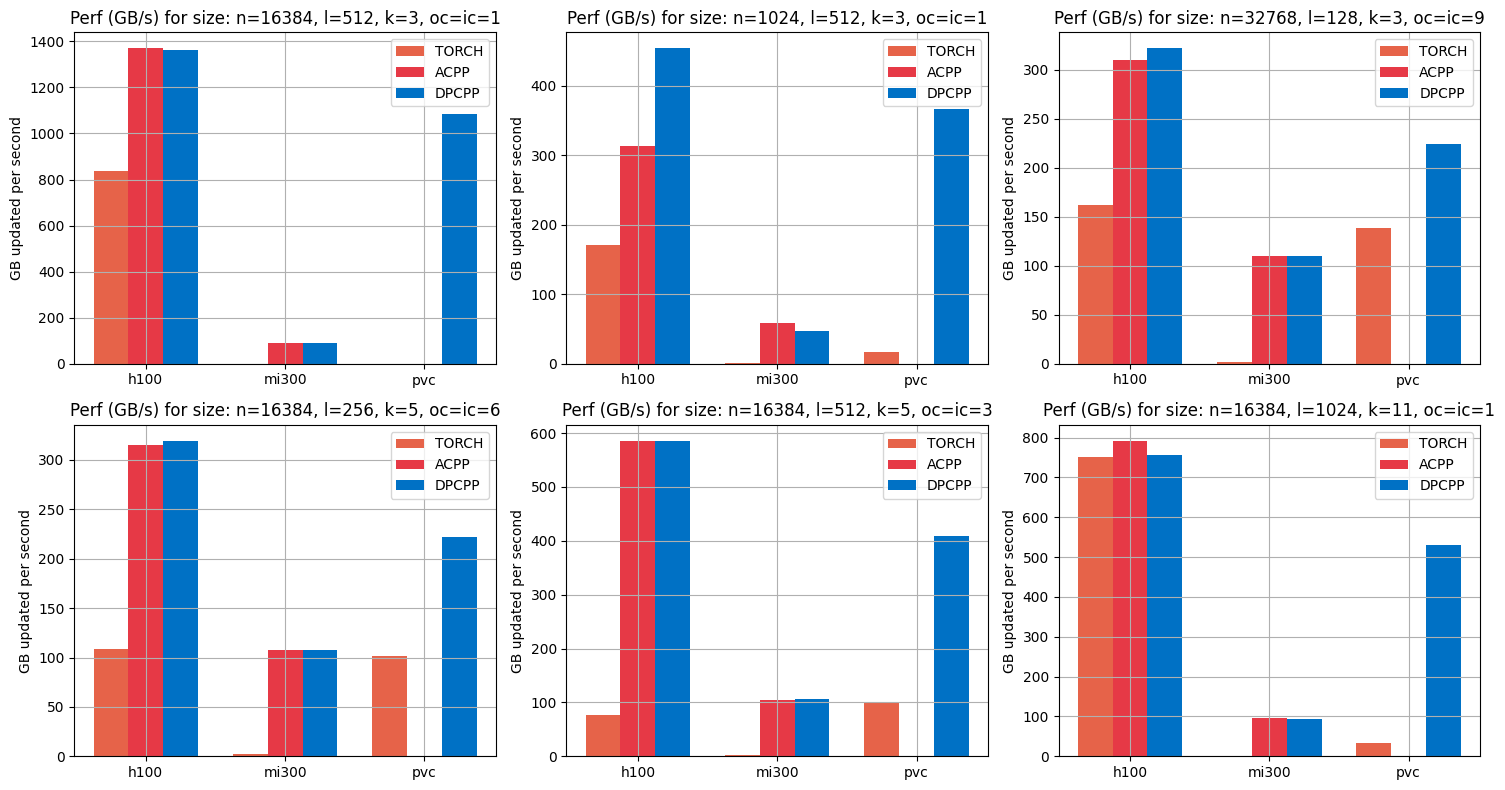

In [6]:
import json
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Charger les données depuis un fichier
with open("conv1d.json", "r") as f:
    data = json.load(f)["RESULTS"]

# Grouper les résultats par (batch_size, input_length, kernel_size, channels)
grouped = {}
for entry in data:
    key = (
        entry["batch_size"],
        entry["input_length"],
        entry["kernel_size"],
        entry["channels"]
    )
    grouped.setdefault(key, {})[entry["impl"].upper()] = {
        "h100": entry["h100_perf"] if isinstance(entry["h100_perf"], (int, float)) else None,
        "mi300": entry["mi300_perf"] if isinstance(entry["mi300_perf"], (int, float)) else None,
        "pvc": entry["pvc_perf"] if isinstance(entry["pvc_perf"], (int, float)) else None
    }

fig = plt.figure(figsize=(15, 8))
gs = gridspec.GridSpec(2, 3)
colors = {"TORCH": "#e66349", "ACPP": "#E63946", "DPCPP": "#0071C5"}

for idx, ((n, l, k, c), impls) in enumerate(grouped.items()):
    ax = fig.add_subplot(gs[idx])
    width = 0.25
    labels = ["h100", "mi300", "pvc"]
    x = range(len(labels))

    for i, impl in enumerate(["TORCH", "ACPP", "DPCPP"]):
        if impl in impls:
            y = [impls[impl].get(device) or 0 for device in labels]
            ax.bar([p + i * width for p in x], y, width=width, label=impl, color=colors[impl])

    ax.set_xticks([p + width for p in x])
    ax.set_xticklabels(labels)
    ax.set_ylabel("GB updated per second")
    ax.set_title(f"Perf (GB/s) for size: n={n}, l={l}, k={k}, oc=ic={c}")
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.savefig("conv1D_bench.pdf")
plt.show()
